<a href="https://colab.research.google.com/github/Danika-Balas/msds-458/blob/master/458_Assignment1_Expt3_DropoutGridSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup and Preprocessing

In [22]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid")

from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
keras.__version__

'2.3.0-tf'

In [23]:
tf.__version__

'2.2.0-rc3'

In [0]:
from keras import metrics

In [0]:
# neccessary for K.gradient to work in TensorFlow 2.x
# only needed for the "Finding a pattern the hidden node maximally responds to" section below.
# but disabled to make Tensorboard work...
tf.compat.v1.disable_eager_execution() 

In [0]:
# Set see in order to achieve consistent results across runs
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

####Import MNIST dataset

In [0]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [28]:
train_images.shape, test_images.shape, test_labels.shape, test_labels.shape

((60000, 28, 28), (10000, 28, 28), (10000,), (10000,))

In [29]:
#Store copy of training images in order to easily view images even after transformation are performed
example_train_images = train_images.copy()
example_train_images.shape

(60000, 28, 28)

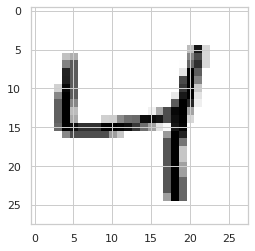

In [30]:
# Example of a single sample, a 28x28 pixel image of a handwritten digit
digit = example_train_images[2]

plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

####Prepare the data

In [0]:
# Reshape the data into the shape that the network expects
train_images = train_images.reshape((60000, 28 * 28))

# Scale the data to [0,1] interval
train_images = train_images.astype('float32') / 255

# Do the same for the test dataset
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

In [0]:
# Split training data into training set and validation set
val_images, train_images = train_images[:5000], train_images[5000:]
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

#Experiment 3

We will fine-tune the hyperparameters of the model until we find the 'best' model according to our selected metrics

In [0]:
# Function builds models with 1 hidden layer (by default), then the same number of nodes in each hidden layer
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model(n_hidden=1, n_neurons=2, learning_rate=0.001, input_shape=(28 * 28,)):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    model.add(keras.layers.Dense(85, activation="relu"))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dropout(0.25))
    model.add(layers.Dense(10, activation='softmax'))
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy'])
    return model

In [0]:
# This function builds models with varying number of nodes in each hidden layer
def build_model2(n_neurons=(2,3), learning_rate=0.001, input_shape=(28 * 28,)):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    for layer in range(len(n_neurons)):
        model.add(keras.layers.Dense(n_neurons[layer], activation="relu"))
    model.add(layers.Dense(10, activation='softmax'))
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy'])
    return model

In [0]:
# Function builds models with 1 hidden layer (by default), then the same number of nodes in each hidden layer
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model3(n_hidden=1, n_neurons=2, learning_rate=0.001, input_shape=(28 * 28,), n_dropout=0.05):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    model.add(keras.layers.Dense(110, activation="relu"))
    model.add(keras.layers.Dropout(n_dropout))
    model.add(layers.Dense(10, activation='softmax'))
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy'])
    return model

In [0]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
keras_clf = KerasClassifier(build_model3)

In [41]:
#param_grid = {'n_neurons': range(680,720,5)}
param_grid = {'n_dropout': (0,0.05,0.1,0.15,0.2,0.25,0.3)}
param_grid

{'n_dropout': (0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3)}

Use grid search to train models with different combinations of parameter values

In [42]:
from sklearn.model_selection import GridSearchCV

grid_cv = GridSearchCV(estimator=keras_clf, param_grid=param_grid,cv=3,verbose = 2)
grid_cv.fit(train_images, train_labels, epochs=30,
                  validation_data=(val_images, val_labels),
                  callbacks=[keras.callbacks.EarlyStopping(patience=2)])

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] n_dropout=0 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 36666 samples, validate on 5000 samples
Epoch 1/30
36666/36666 [==============================] - 4s 121us/sample - loss: 0.3285 - accuracy: 0.9073 - val_loss: 0.1801 - val_accuracy: 0.9510
Epoch 2/30
36666/36666 [==============================] - 4s 110us/sample - loss: 0.1547 - accuracy: 0.9550 - val_loss: 0.1321 - val_accuracy: 0.9638
Epoch 3/30
36666/36666 [==============================] - 4s 116us/sample - loss: 0.1062 - accuracy: 0.9690 - val_loss: 0.1065 - val_accuracy: 0.9684
Epoch 4/30
36666/36666 [==============================] - 4s 108us/sample - loss: 0.0803 - accuracy: 0.9753 - val_loss: 0.1023 - val_accuracy: 0.9678
Epoch 5/30
36666/36666 [==============================] - 4s 108us/sample - loss: 0.0621 - accuracy: 0.9807 - val_loss: 0.0981 - val_accuracy: 0.9724
Epoch 6/30
36666/36666 [==============================] - 4s 106us/sample - loss: 0.0493 - accuracy: 0.9851 - val_loss: 0.0940 - val_accuracy: 0.9726
Epoch 7/30
36666/36666 [===========================

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   42.4s remaining:    0.0s


Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 4s 115us/sample - loss: 0.3250 - accuracy: 0.9082 - val_loss: 0.1799 - val_accuracy: 0.9532
Epoch 2/30
36667/36667 [==============================] - 4s 111us/sample - loss: 0.1504 - accuracy: 0.9567 - val_loss: 0.1318 - val_accuracy: 0.9646
Epoch 3/30
36667/36667 [==============================] - 4s 111us/sample - loss: 0.1056 - accuracy: 0.9685 - val_loss: 0.1107 - val_accuracy: 0.9676
Epoch 4/30
36667/36667 [==============================] - 4s 106us/sample - loss: 0.0793 - accuracy: 0.9763 - val_loss: 0.0981 - val_accuracy: 0.9716
Epoch 5/30
36667/36667 [==============================] - 4s 111us/sample - loss: 0.0596 - accuracy: 0.9823 - val_loss: 0.0987 - val_accuracy: 0.9688
Epoch 6/30
36667/36667 [==============================] - 4s 105us/sample - loss: 0.0473 - accuracy: 0.9855 - val_loss: 0.0904 - val_accuracy: 0.9740
Epoch 7/30
36667/36667 [===========================

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 16.1min finished


Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 7s 120us/sample - loss: 0.3198 - accuracy: 0.9070 - val_loss: 0.1463 - val_accuracy: 0.9598
Epoch 2/30
55000/55000 [==============================] - 6s 115us/sample - loss: 0.1590 - accuracy: 0.9526 - val_loss: 0.1155 - val_accuracy: 0.9662
Epoch 3/30
55000/55000 [==============================] - 6s 113us/sample - loss: 0.1218 - accuracy: 0.9633 - val_loss: 0.0999 - val_accuracy: 0.9710
Epoch 4/30
55000/55000 [==============================] - 6s 114us/sample - loss: 0.1011 - accuracy: 0.9695 - val_loss: 0.0888 - val_accuracy: 0.9762
Epoch 5/30
55000/55000 [==============================] - 6s 107us/sample - loss: 0.0881 - accuracy: 0.9725 - val_loss: 0.0816 - val_accuracy: 0.9770
Epoch 6/30
55000/55000 [==============================] - 6s 109us/sample - loss: 0.0759 - accuracy: 0.9760 - val_loss: 0.0766 - val_accuracy: 0.9778
Epoch 7/30
55000/55000 [===========================

GridSearchCV(cv=3, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f79d5901a58>,
             iid='deprecated', n_jobs=None,
             param_grid={'n_dropout': (0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

##EVALUATE

### Inspecting the best estimator

Let's get the number of neurons that produced the best estimator

In [43]:
grid_cv.best_params_

{'n_dropout': 0.2}

Let's get the rsults to compare the performance of the 100 models.

In [44]:
results = grid_cv.cv_results_
results

{'mean_fit_time': array([38.57532223, 35.02270214, 52.35684395, 44.1775624 , 48.41713222,
        48.62662633, 48.4961946 ]),
 'mean_score_time': array([0.94864575, 0.98161713, 0.99158804, 0.96690671, 1.0049475 ,
        1.0106651 , 1.06902782]),
 'mean_test_score': array([0.96963638, 0.97134546, 0.97236363, 0.97103633, 0.97432727,
        0.9709091 , 0.97067277]),
 'param_n_dropout': masked_array(data=[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_dropout': 0},
  {'n_dropout': 0.05},
  {'n_dropout': 0.1},
  {'n_dropout': 0.15},
  {'n_dropout': 0.2},
  {'n_dropout': 0.25},
  {'n_dropout': 0.3}],
 'rank_test_score': array([7, 3, 2, 4, 1, 5, 6], dtype=int32),
 'split0_test_score': array([0.9695102 , 0.97109199, 0.97223735, 0.9725101 , 0.97491002,
        0.97180104, 0.96923751]),
 'split1_test_score': array([0.96972674, 0.97092676, 0.97299951, 0.96879941, 0.973

In [45]:
results['params'], results['rank_test_score']

([{'n_dropout': 0},
  {'n_dropout': 0.05},
  {'n_dropout': 0.1},
  {'n_dropout': 0.15},
  {'n_dropout': 0.2},
  {'n_dropout': 0.25},
  {'n_dropout': 0.3}],
 array([7, 3, 2, 4, 1, 5, 6], dtype=int32))

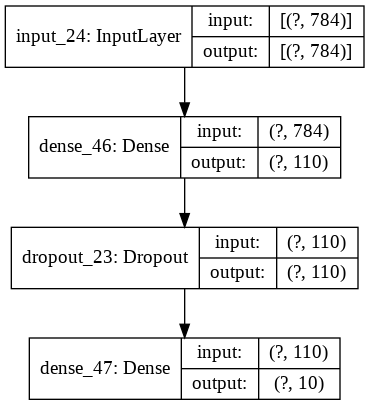

In [46]:
best_model = grid_cv.best_estimator_.model
keras.utils.plot_model(best_model, show_shapes=True)

In [47]:
best_model.evaluate(test_images, test_labels)

[0.07647609669162193, 0.9771]